In [71]:
import numpy as np
import math
from random import seed
from random import random
from numba import jit
from time import time

import functions
from functions import TestResult
from functions import read_tsp_file
from functions import comp_shortest_path

## Compute shortest path for cooling schedules 

In [73]:

from functions import distance_matrix
from functions import total_dist
from functions import generate_i_j
from functions import two_opt_swap

def comp_shortest_path_log_schedule(T_start, T_end,cooling_parameter,max_itr, nMarkov, coords, dataset,schedule, save_data=False):
    """Function that computes the shortest path for the Traveling Salesman Problem using Simulated Annealing.
       It also returns the acceptance probability of a new route from T_start to T_end

        Args:
            T_start (float): Starting temperature
            T_end (float): Temperature that determines when the Anealing process stops
            nMarkov (int): Length of the markov chain
            coords (numpy.ndarray): coordinate array with tuples of city coordinates in the form: ()
            max_itr : number of iterations same as for geometric scheduling
            cooling_parameter : paramter for a  cooling schedule
            schedule : geo,log,linear

        Returns:
            tuple: [0] final number of iterations, [1]minimal cost, [2]optimal cities list,[3]local minimum costs,
            [4]Temperature list,[5] minimum cost achieved in each iteration
            
    """
    T = T_start
    itr = 0
    matrix = distance_matrix(coords)

    route = np.arange(1,len(coords))
    np.random.shuffle(route)

     # starts and end at the first node in route/
    route = np.append(route,0)
    route = np.append(0,route)

    num_cities = len(route)

    old_cost = total_dist(route,matrix)
    min_cost = old_cost

    best_cost_till_now = []
    new_cost_arr = []

    new_cost = old_cost
    optimal_list_cities = route
    
    acceptance_probability = []
    temperature_range = []
    min_cost_itr = []

    start_time = time()
    while T >= T_end:
        if(itr >= max_itr):
            break
        accepted_routes_T = 0
        for k in range(nMarkov):    # Markov
            i,j = generate_i_j(num_cities)

            new_cost = old_cost - (matrix[route[i-1]][route[i]] + matrix[route[j+1]][route[j]]) + (matrix[route[i-1]][route[j]] + matrix[route[j+1]][route[i]])
            

            cost_difference = new_cost - old_cost

            new_cost_arr.append(new_cost)


            if(new_cost < min_cost):
            
                min_cost = new_cost
                best_cost_till_now.append(min_cost)

            if(cost_difference < 0):
                prob = 1
            else:
                prob = np.minimum(math.exp(-cost_difference/T),1)

            random_num = np.random.uniform()
            

            # Accept it
            if(random_num <= prob):
                route = two_opt_swap(route,i,j)
                old_cost = new_cost
                optimal_list_cities = route
                accepted_routes_T +=1

        
        acceptance_probability.append(accepted_routes_T/nMarkov)
        temperature_range.append(T)

        
        itr = itr + 1
        if(schedule == "log"):
            T = T_start/(1+cooling_parameter*np.log(itr+1))
        elif(schedule == "linear"):
            T = T - cooling_parameter
        else:
            T = T * cooling_parameter
            # default goes to geometric scheduling
            
        # After each iteration
        min_cost_itr.append(min_cost)
    
    comp_time = time() - start_time
    best_cost_till_now_ar = np.asarray(best_cost_till_now)
    
    if save_data:
        result = TestResult(min_cost, optimal_list_cities, itr, comp_time, dataset, T_start, T_end,best_cost_till_now_ar,cooling_parameter, n_markov=nMarkov)
        result.save_to_csv()


    return itr, min_cost, optimal_list_cities,best_cost_till_now,temperature_range,min_cost_itr,acceptance_probability



## Comparison of Cooling Schedules - Linear, Geometric, Logarithmic

In [77]:
import numpy as np
nMarkov = 10000
num_simulations = 10
max_itr = 1215

In [78]:
cooling_parameter_arr = [1,0.825,0.99]

T_end = 0.005

coords = read_tsp_file("TSP-Configurations/a280.tsp")
dataset = "a280"
schedule_arr = ["log","linear","geometric"]
min_cost_arr = []
temperature_range_schedule = []
acceptance_probability_schedule = []

for i in range(len(schedule_arr)):
    schedule = schedule_arr[i]
    # It is a slow cooling schedule therefore T_start = 1
    if(schedule == "log"):
        T_start = 1
    else:
        T_start = 1000
    cooling_parameter = cooling_parameter_arr[i]
    min_cost_schedule = []
    for i in range(num_simulations):
        itr, min_cost, optimal_list_cities,best_cost_till_now,temperature_range,min_cost_itr,acceptance_probability = comp_shortest_path_log_schedule(T_start, T_end,cooling_parameter,max_itr, nMarkov, coords, dataset,schedule, save_data=True)
        min_cost_schedule.append(min_cost)
        
    min_cost_arr.append(min_cost_schedule)
    temperature_range_schedule.append(temperature_range)
    acceptance_probability_schedule.append(acceptance_probability)
    



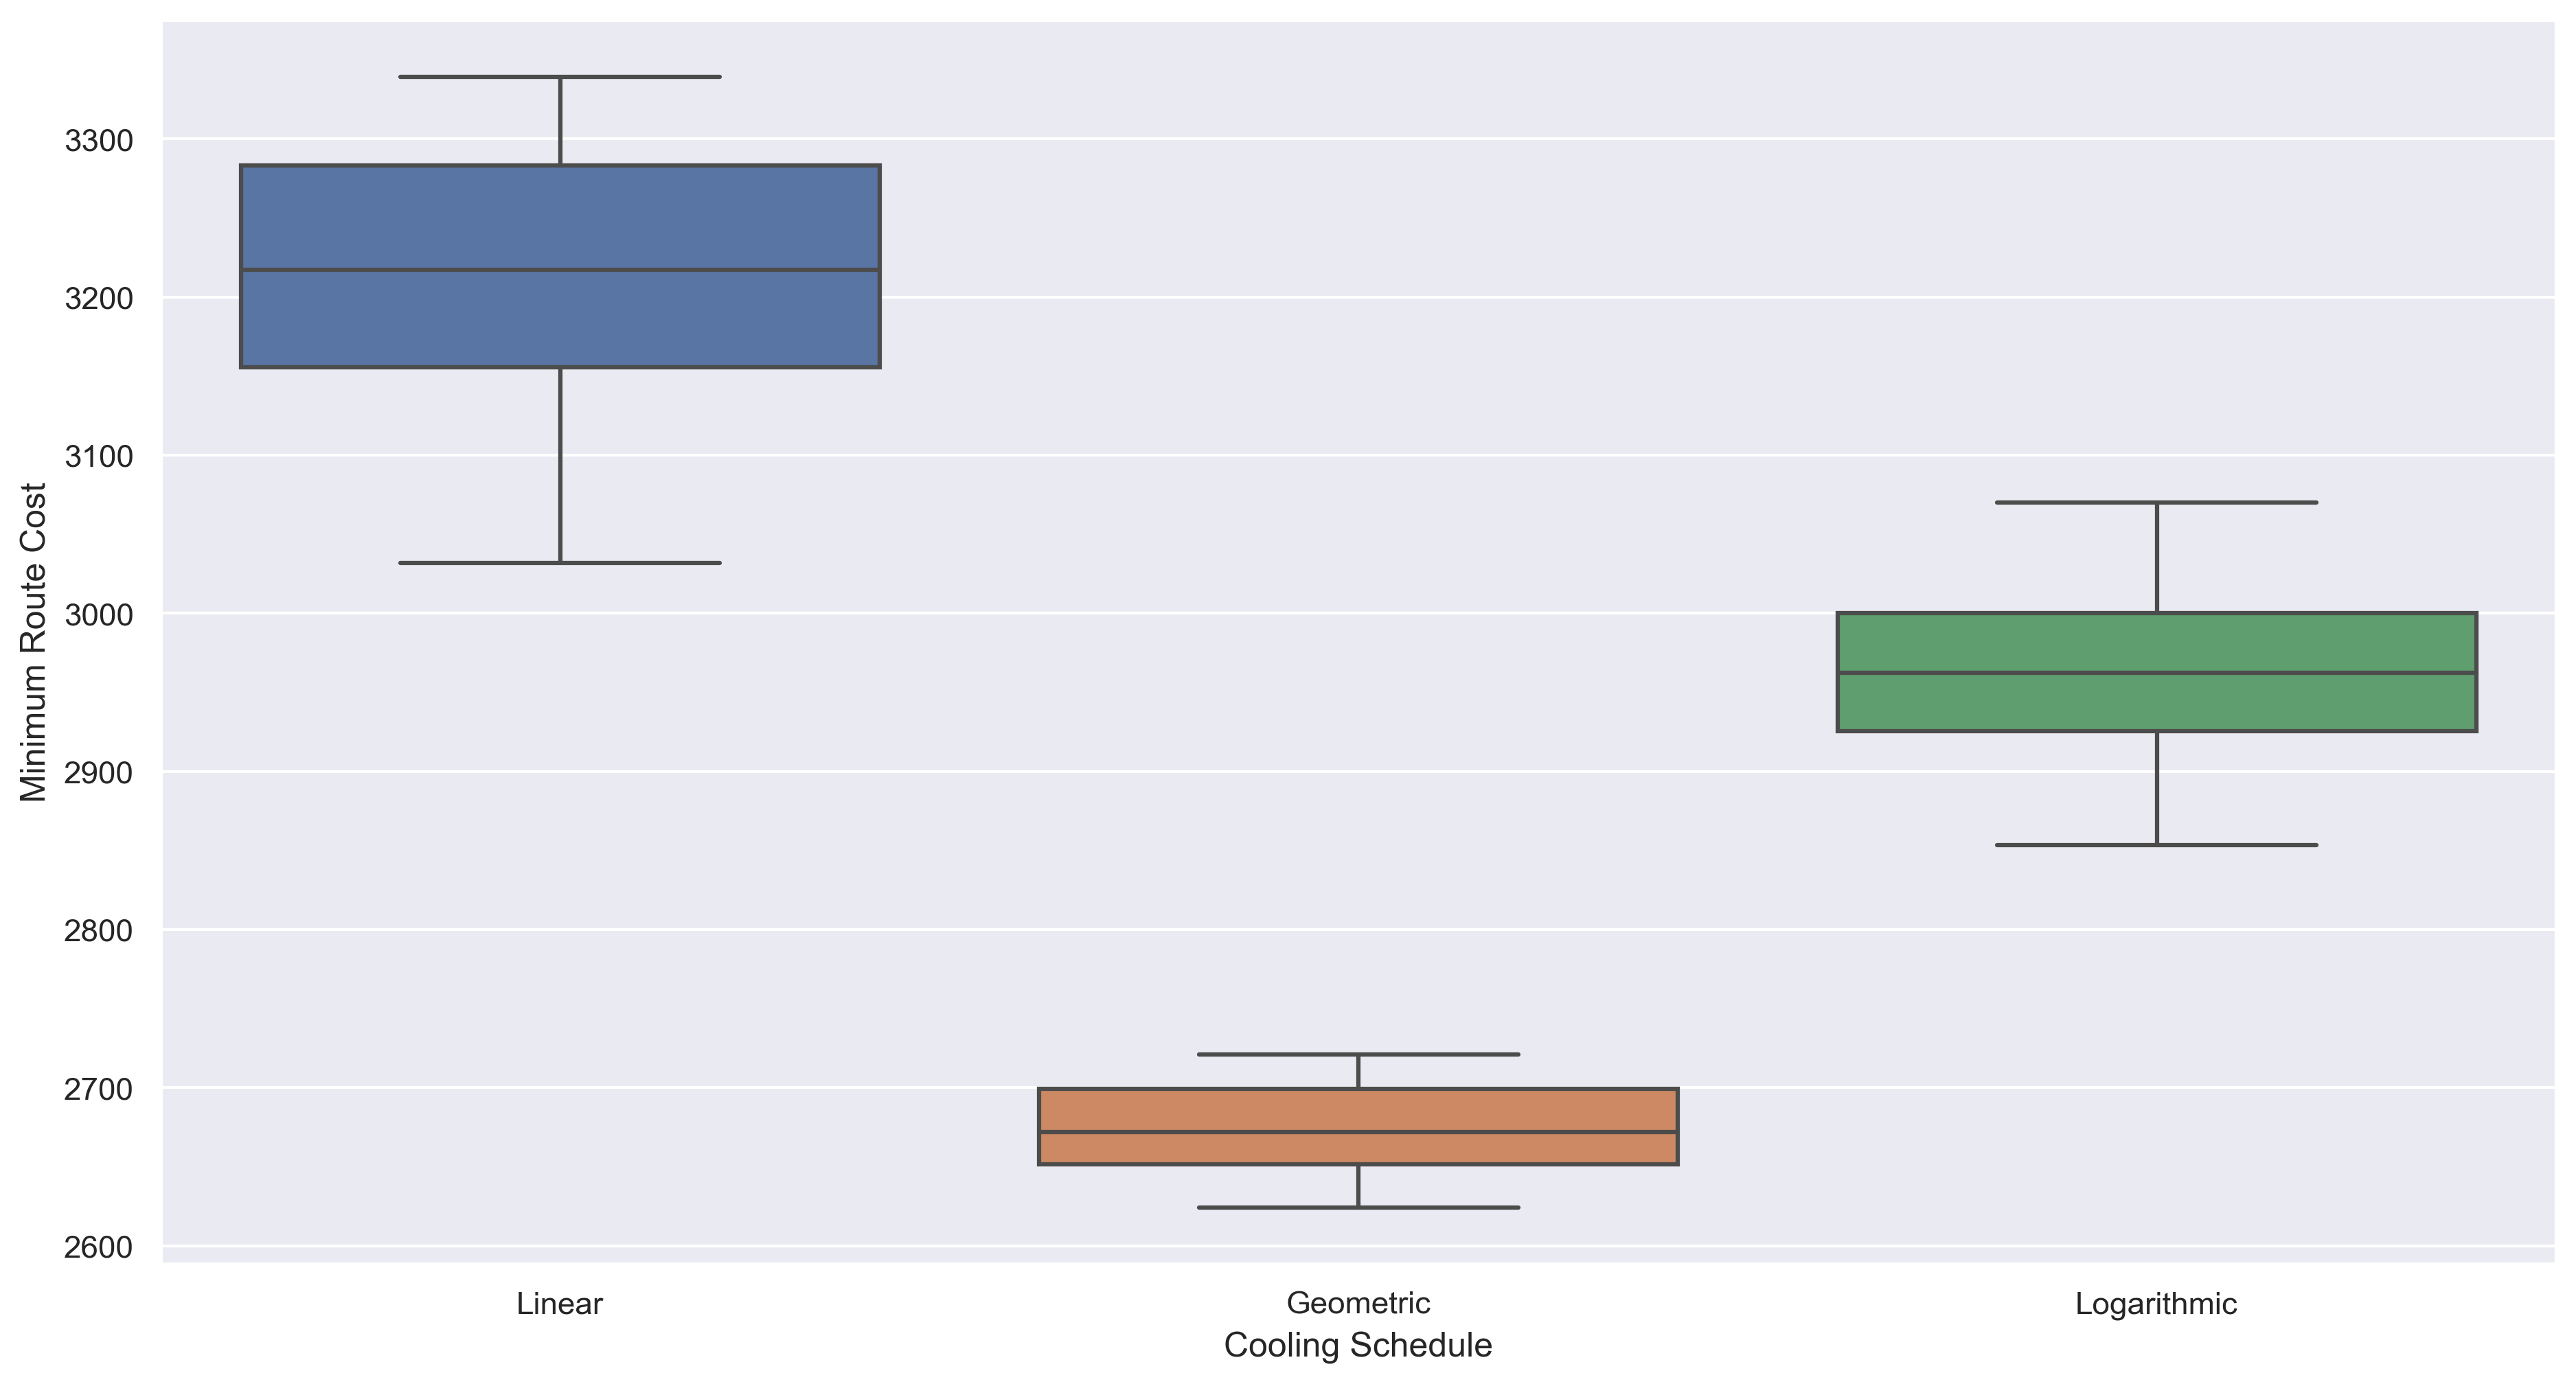

In [84]:

from pandas import read_csv
import seaborn as sns

File_Path = "data/TSP_SA_Cooling_Schedule.csv"
df_1 = read_csv(File_Path)

sns.set(rc = {'figure.figsize':(15,8)})

sns.set(rc={"figure.dpi":300})

ax = sns.boxplot(x="Cooling Factor", y="Minimal Cost", data=df_1)

ax.set_xticklabels(["Linear","Geometric","Logarithmic"])
ax.set(xlabel='Cooling Schedule', ylabel='Minimum Route Cost')

plt.show()

In [113]:
df_1.head()
df_stats = df_1[["Minimal Cost","Cooling Factor"]]
df_stats = df_stats.groupby("Cooling Factor")

df_stats_res = df_stats.describe()
df_stats_res

Minimal Cost                                                    \
                      count         mean        std          min          25%   
Cooling Factor                                                                  
0.825                  10.0  3212.276467  92.958650  3031.719973  3155.803787   
0.990                  10.0  2673.450435  31.916726  2624.264948  2651.677996   
1.000                  10.0  2963.951289  67.404327  2853.249863  2925.360127   

                                                       
                        50%          75%          max  
Cooling Factor                                         
0.825           3217.349989  3283.250441  3339.431138  
0.990           2672.001225  2699.186248  2720.923870  
1.000           2962.391970  3000.167857  3070.267233

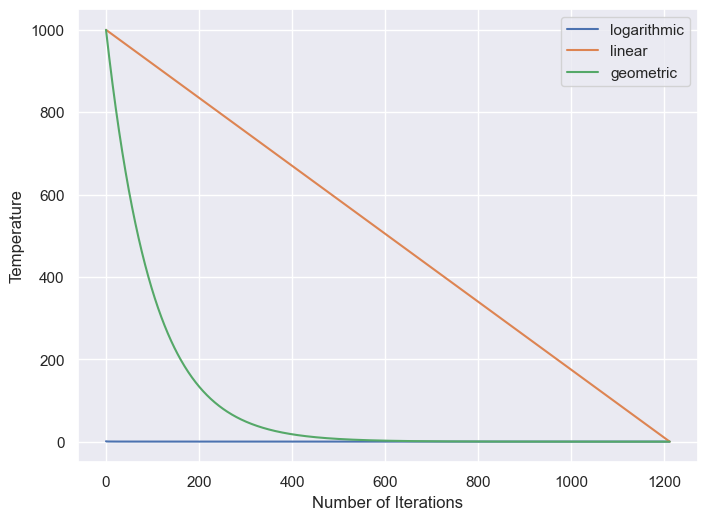

In [105]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=100)

x_data = np.arange(0,itr-2,1)

plt.plot(x_data,temperature_range_schedule[0][:-2],label="logarithmic")  # log
plt.plot(temperature_range_schedule[1],label="linear")  # linear
plt.plot(temperature_range_schedule[2][:-2],label="geometric")  # geometric
plt.legend()
plt.ylabel("Temperature")
plt.xlabel("Number of Iterations")
#plt.yscale('log')
plt.show()